Cross-validation to determine how many canonical components (or latent dimension). We want the canonical components that have an r2 value greater than the r2 value of the first canonical component of the null model. "Plot eigenvalues (r2)" helps visualize that.\
U and V are the latent variables of X and Y. A and B are the canonical weights or coefficients (tell us how each variable such as the gains/time latency) are related). Essentially X=AU, Y=BV. We can use pseudoinverse to solve and get back from the latent space to the actual X and Y space.

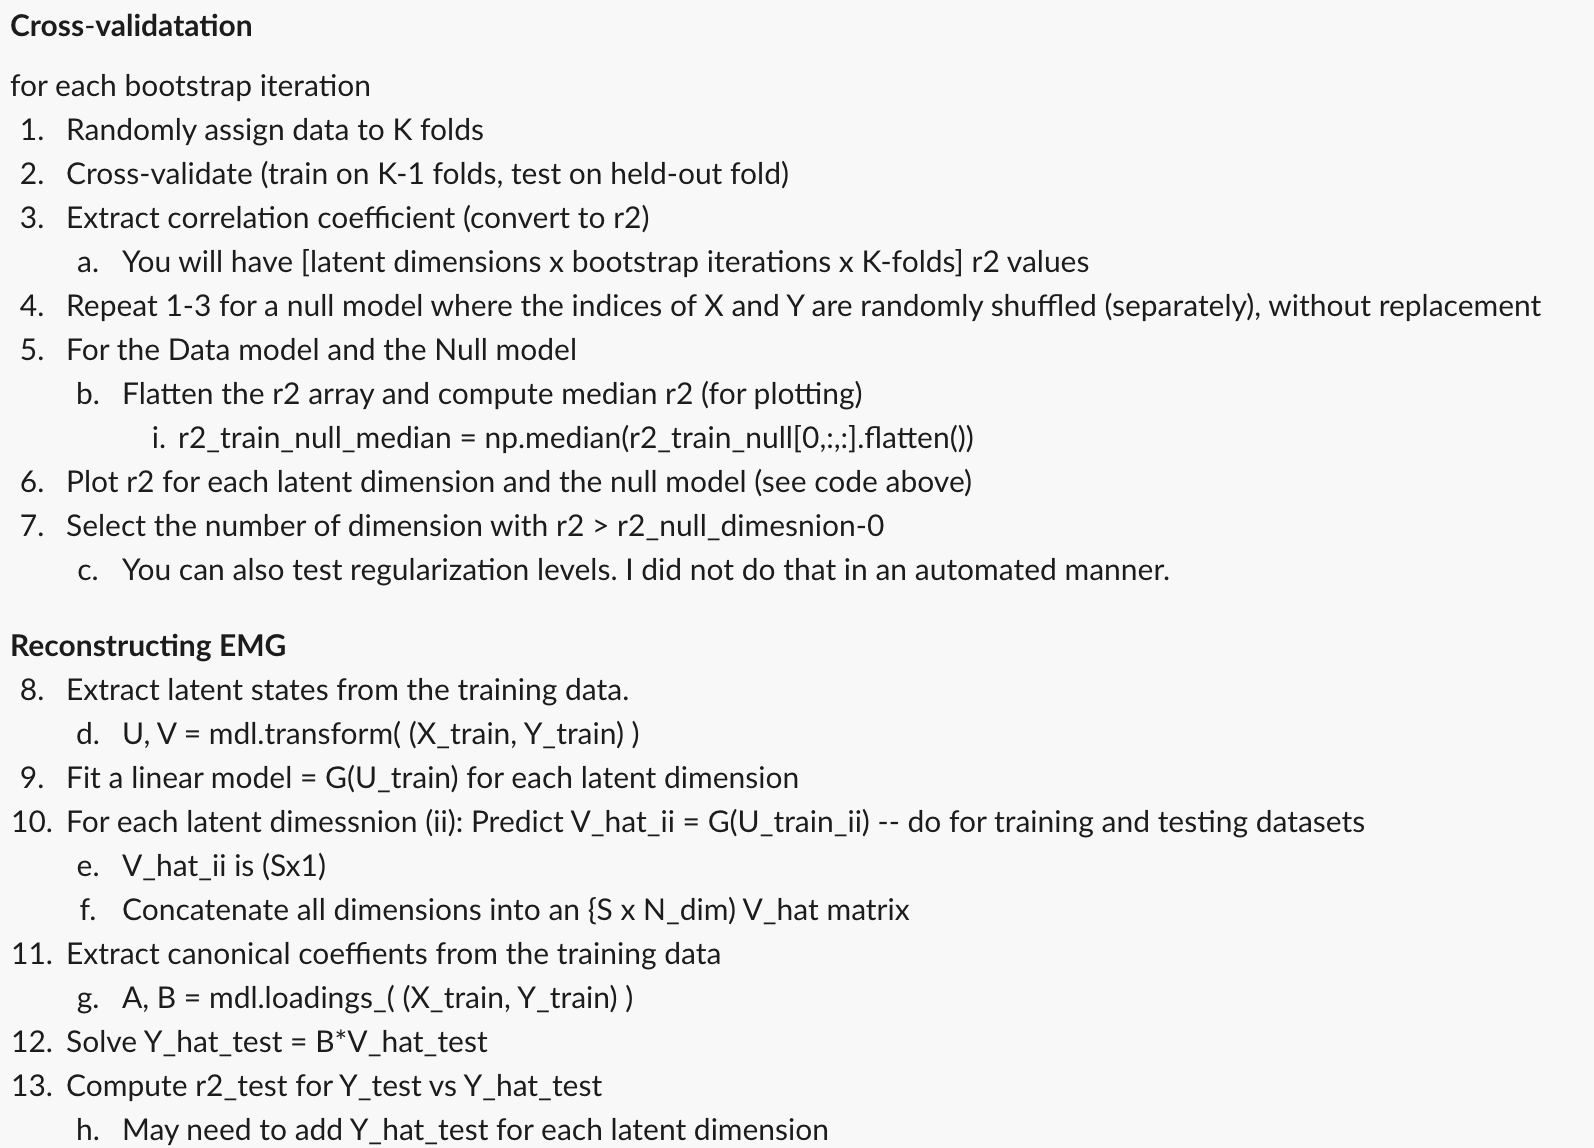

In [ ]:
!pip install cca-zoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.2/115.2 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 12.6 MB/s eta 0:00:00


In [9]:
import pandas as pd
from cca_zoo import linear as czoo
from cca_zoo import model_selection as modSelect
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

# Assign data
latentDim = 15


"""file_path = 'wavedata_EEG_unfiltered.csv'  # Replace with your CSV file path

with open(file_path, 'r') as csvfile:
    csvreader = csv.reader(csvfile)

    # Skip header (if exists)
    next(csvreader)  # Skip the header row

    for row in csvreader:
        # Process each row
        print(row)"""

df = pd.read_excel('wavedata_EEG_unfiltered.xlsx', header = None)
X = df.values
df = pd.read_excel('wavedata_EMG_unfiltered.xlsx', header = None)
Y = df.values


X = X[:, :200]
Y = Y[:, :200]
print(X.shape)
print(Y.shape)

# Build model
mdl = czoo.rCCA(latent_dimensions = latentDim,  c=1)

# Fit model
mdl.fit( (X, Y) )

# Extract parameters
r2 = np.square(mdl.average_pairwise_correlations( (X, Y) ))

#A, B = mdl.loadings_( (X, Y) )
U, V = mdl.transform( (X, Y) )


(108, 200)
(108, 200)


(108, 1400)


In [10]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

#Splitting data into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3,random_state = 0)

In [11]:
import random

# Cross validation
BI = 1
K = 5
r2_train = np.zeros((latentDim, BI, K))
r2_train_null = np.zeros((latentDim, BI, K))
r2_test = np.zeros((latentDim, BI, K))
r2_test_null = np.zeros((latentDim, BI, K))

for ii in range(BI):
  k_fold = KFold(n_splits=K, shuffle=True, random_state=ii)

  for fold_index, (train_index, test_index) in enumerate(k_fold.split(X_train)):
    X_train_cv = X_train[train_index,:]
    Y_train_cv = Y_train[train_index,:]
    X_test_cv = X_train[test_index,:]
    Y_test_cv = Y_train[test_index,:]

    # within sample
    #initialize model
    mdl = czoo.rCCA(latent_dimensions = latentDim,  c=1)
    #fit model on training data
    mdl.fit((X_train_cv, Y_train_cv))

    X_transform, Y_transform = mdl.transform((X_train_cv, Y_train_cv))
    temp = np.square(mdl.average_pairwise_correlations((X_train_cv, Y_train_cv)))
    r2_train[:, ii, fold_index] = temp

    #null model: shuffle indices
    Xnull_train = X_train_cv[random.sample(range(0, len(X_train_cv)),  len(X_train_cv))]
    Ynull_train = Y_train_cv[random.sample(range(0, len(Y_train_cv)),  len(Y_train_cv))]
    print(Xnull_train.shape)

    mdl.fit((Xnull_train, Ynull_train))

    Xnull_transform, Ynull_transform = mdl.transform((Xnull_train, Ynull_train))
    r2_train_null[:, ii, fold_index] = np.square(mdl.average_pairwise_correlations((Xnull_train, Ynull_train)))

    # out of sample

    X_test_transform, Y_test_transform = mdl.transform((X_test_cv, Y_test_cv))
    temp = np.square(mdl.average_pairwise_correlations((X_test_cv, Y_test_cv)))
    r2_test[:, ii, fold_index] = temp

    #null model: shuffle indices
    Xnull_test = X_test_cv[random.sample(range(0, len(X_test_cv)),  len(X_test_cv))]
    Ynull_test = Y_test_cv[random.sample(range(0, len(Y_test_cv)),  len(Y_test_cv))]
    print(Xnull_test.shape)

    Xnull_transform, Ynull_transform = mdl.transform((Xnull_test, Ynull_test))
    r2_test_null[:, ii, fold_index] = np.square(mdl.average_pairwise_correlations((Xnull_test, Ynull_test)))


(60, 200)
(15, 200)
(60, 200)
(15, 200)
(60, 200)
(15, 200)
(60, 200)
(15, 200)
(60, 200)
(15, 200)


In [12]:
  print(len(X_train))

  for fold_index, (train_index, test_index) in enumerate(k_fold.split(X_train)):
    print(np.sort(train_index))

    #X_test_cv = X_test[test_index,:]
  #len(X_train_cv)
  #len(X_test_cv)

75
[ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24 25
 27 29 30 31 32 35 36 37 38 39 42 44 45 46 47 48 49 50 51 53 55 56 58 60
 61 62 63 64 65 67 68 69 70 71 72 73]
[ 0  1  3  5  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 51 52 53 54 55 57
 58 59 61 63 64 66 67 69 71 72 73 74]
[ 0  2  4  5  6  7  8  9 11 12 13 15 16 17 18 20 21 22 23 24 25 26 27 28
 33 34 35 36 37 39 40 41 43 44 45 46 47 48 49 50 51 52 53 54 56 57 58 59
 60 62 64 65 66 67 68 69 70 71 73 74]
[ 1  2  3  4  6  7  9 10 11 12 14 17 19 21 22 23 24 26 27 28 29 30 31 32
 33 34 36 38 39 40 41 42 43 44 45 46 47 48 49 50 52 54 55 56 57 58 59 60
 61 62 63 64 65 66 67 68 70 71 72 74]
[ 0  1  2  3  4  5  6  7  8 10 11 13 14 15 16 18 19 20 22 25 26 27 28 29
 30 31 32 33 34 35 37 38 40 41 42 43 45 48 49 50 51 52 53 54 55 56 57 59
 60 61 62 63 65 66 68 69 70 72 73 74]


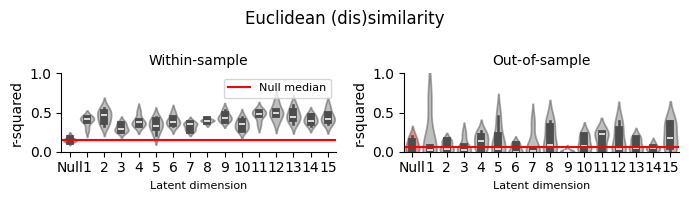

In [13]:
# Plotting eigenvalues (r2)

# Create a figure and axes
fig = plt.figure(figsize=(7,2))
xlabs = ['Null']
for ii in range(1,latentDim+1):
  xlabs.append(str(ii))

#################################################
################# Within-sample #################
#################################################
# Create a list of jittered data samples
ax = plt.subplot(1,2,1)

# Plot the null model
sns.violinplot(x = 0*np.ones_like(r2_train_null[0,:,:].flatten()), y = r2_train_null[0,:,:].flatten(), color = 'red', fill = True, alpha = 0.5)

# Plot the data samples
temp = r2_train.reshape(-1, r2_train.shape[1]*r2_train.shape[2]).T
for ii in range(latentDim):
  x_r2 = r2_train[ii,:,:].flatten()
  #plt.plot((ii+1)*np.ones_like(x_r2)+ np.random.normal(scale=0.05, size = np.shape(x_r2)), x_r2 , '.', color='gray', alpha=0.2, markersize = 2)
  sns.violinplot(x = (ii+1)*np.ones_like(temp[:,ii]), y = temp[:,ii], color = 'gray', fill = True, alpha = 0.5)
  #plt.boxplot(r2_train.reshape(-1, r2_train.shape[1]*r2_train.shape[2]).T , widths=0.5, boxprops=dict(color='black'),
  #medianprops=dict(color='black'), patch_artist=False)

# Plot null model ################
# Median and 95% CI
r2_train_null_median = np.median(r2_train_null[0,:,:].flatten())
plt.axhline(r2_train_null_median, color = 'red', label = 'Null median')
#r2_train_null_CI95 = np.percentile(r2_train_null[0,:,:].flatten(), [2.5, 97.5])
#plt.axhspan(ymin=r2_train_null[0], ymax=r2_train_null[1], alpha=0.15, color='red', label = 'Null 95% CI')
plt.title('Within-sample', fontsize = 10)
plt.xlabel('Latent dimension', fontsize = 8)
plt.ylabel('r-squared')
plt.ylim([0,1])
plt.legend(fontsize = 8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(np.arange(len(xlabs)), labels = xlabs)

#################################################
################# Out-of-sample #################
#################################################
ax = plt.subplot(1,2,2)

# Plot the null model
sns.violinplot(x = 0*np.ones_like(r2_test_null[0,:,:].flatten()), y = r2_test_null[0,:,:].flatten(), color = 'red', fill = True, alpha = 0.5)

# Plot the data samples
temp = r2_test.reshape(-1, r2_test.shape[1]*r2_test.shape[2]).T

for ii in range(latentDim):
  x_r2 = r2_test[ii,:,:].flatten()
  #plt.plot((ii+1)*np.ones_like(x_r2)+ np.random.normal(scale=0.05, size = np.shape(x_r2)), x_r2 , '.', color='gray', alpha=0.2, markersize = 2)
  sns.violinplot(x = (ii+1)*np.ones_like(temp[:,ii]), y = temp[:,ii], color = 'gray', fill = True, alpha = 0.5)
  #plt.boxplot(r2_test.reshape(-1, r2_test.shape[1]*r2_test.shape[2]).T , widths=0.5, boxprops=dict(color='black'),
  #medianprops=dict(color='black'), patch_artist=False)

# Plot null model ################
# Median and 95% CI
r2_test_null_median = np.median(r2_test_null[0,:,:].flatten())
plt.axhline(r2_test_null_median, color = 'red', label = 'Null median')
#plt.axhspan(ymin=r2_test_null_CI95[0], ymax=r2_test_null_CI95[1], alpha=0.15, color='red', label = 'Null 95% CI')
plt.title('Out-of-sample', fontsize = 10)
plt.xlabel('Latent dimension', fontsize = 8)
plt.ylabel('r-squared')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.suptitle('Euclidean (dis)similarity')
plt.xticks(np.arange(len(xlabs)), labels = xlabs)
plt.ylim([0,1])
plt.tight_layout()
plt.show()


In [ ]:
r2_train_null[0,:,:].flatten()

array([0.16527079, 0.17696497, 0.40447783, 0.13959097, 0.15132479])

[[ 3.13233582e-01]
 [ 2.22692338e-01]
 [ 7.54292633e-02]
 [-4.70385070e-03]
 [ 1.89281042e-01]
 [ 3.54005254e-01]
 [ 1.62626602e-01]
 [ 6.21191466e-01]
 [-3.65851742e-01]
 [-3.63350378e-01]
 [-3.90108574e-01]
 [-7.27610532e-02]
 [ 3.26533110e-01]
 [ 1.22492339e-01]
 [ 3.60994808e-02]
 [-7.20341400e-02]
 [-2.44495711e-01]
 [-5.37755494e-02]
 [-4.72315573e-02]
 [ 1.84022074e-01]
 [ 2.01411875e-01]
 [ 2.95054091e-01]
 [ 1.61989456e-01]
 [-1.07765212e-01]
 [-4.23764486e-02]
 [-2.83611355e-01]
 [ 6.35127436e-01]
 [-8.75060433e-02]
 [ 1.39621710e-01]
 [-2.93884696e-01]
 [ 3.41075901e-01]
 [-2.56483077e-01]
 [ 2.10658489e-01]
 [ 1.43281980e-01]
 [-3.32374783e-01]
 [ 2.44682806e-01]
 [-8.15045949e-02]
 [ 1.61211418e-01]
 [-4.76387141e-02]
 [-1.58346012e-02]
 [-2.24490525e-02]
 [-7.00293931e-03]
 [-1.93828996e-01]
 [-2.08947844e-01]
 [ 5.83695800e-02]
 [ 6.21109360e-04]
 [-1.31349085e-01]
 [ 3.18204081e-03]
 [ 1.17384802e-01]
 [ 1.21988356e-01]
 [ 2.18073534e-02]
 [ 9.62525740e-02]
 [-3.7570165

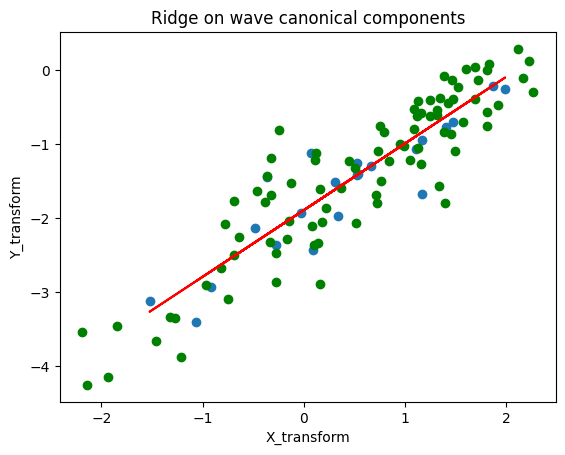

R2:-1555.8601285190734
RMSE: 0.6994312501672469


In [14]:
#Ridge regression implementation

from sklearn.metrics import mean_squared_error
latentDim = 1
lr = Ridge()
#CCA model with 1 latent dimension, regularization coeff = 0.2
mdl = czoo.rCCA(latent_dimensions = latentDim,  c=0.2)
mdl.fit((X, Y))
U,V = mdl.transform((X,Y))

#canonical weights to convert predictions back into XY-space
A, B = mdl.loadings_((X, Y))

U_train, U_test, V_train, V_test = train_test_split(U, V, test_size = 0.2,random_state = 0)
X_train, Y_train, X_test, Y_test = train_test_split(X, Y, test_size = 0.2,random_state = 0)

lr.fit(U_train, V_train)
V_pred = lr.predict(U_test)


#metrics
#RMSE
mse = mean_squared_error(V_test, V_pred)
rmse = np.sqrt(mse)
print(rmse)

#R2 score
r2 = r2_score(V_test, V_pred)
print(r2)

#Plot

plt.scatter(U_test, V_test)
plt.scatter(U_train, V_train, color="green", )
plt.plot(U_test, V_pred, color ="red", )

plt.xlabel("X_transform")
plt.ylabel("Y_transform")

plt.title("Ridge on wave canonical components")
plt.show()

#Convert V_hat back into Y
B_inv = np.linalg.pinv(B)

Y_pred = np.dot(V_pred, np.transpose(B))

#r2 for Y
print("R2:" + str(r2_score(Y_test, Y_pred)))
print("RMSE: " + str(np.sqrt(mean_squared_error(Y_test, Y_pred))))

In [ ]:
# Coefficient plots
mdl = czoo.rCCA(latent_dimensions = latentDim,  c=[c_1,c_2])

# Fit the full model on all data
X = df.iloc[:, 43:47]
Y = df.iloc[:, 79:87]
mdl = mdl.fit( (X, Y) )
fullModel_r2 = np.square(mdl.average_pairwise_correlations( (X, Y) ) ) # r2 on all data
fullModel_A, fullModel_B = mdl.loadings_( (X, Y) )
fullModel_U, fullModel_V = mdl.transform( (X, Y) )
# Plot model coefficients
fig = plt.figure(figsize=(8,7))
numDims = 4
for jj in range(numDims):
  ax = plt.subplot(numDims,2,jj*2+1)
  # PC matrix
  im = plt.bar(np.arange(0, np.shape(rms_array)[1]), fullModel_A[:,jj], color='gray', label = 'median and 95% CI')
  plt.axhline(0, color = 'black', linewidth = .5)
  if jj == 0:
    plt.title('A',fontsize = 10, weight = 'bold')
  if jj < numDims-1:
    plt.xticks([])
  else:
    plt.xticks(np.arange(0, np.shape(rms_array)[1]), labels=rms_labels, rotation=90)
  ax.spines['right'].set_color('none')
  ax.spines['top'].set_color('none')
  # Discrete variable matrix
  ax = plt.subplot(numDims,2,jj*2+2)
  im = plt.bar(np.arange(0, np.shape(clin_array)[1]), fullModel_B[:,jj], color='gray')
  plt.axhline(0, color = 'black', linewidth = .5)
  if jj == 0:
    plt.title('B',fontsize = 10, weight = 'bold')
  if jj < numDims-1:
    plt.xticks([])
  else:
    plt.xticks(np.arange(0, np.shape(clin_array)[1]), labels=clin_labels, rotation=90)
  ax.spines['right'].set_color('none')
  ax.spines['top'].set_color('none')
  fig.text(0.5, 0.9-jj*.05*numDims, 'Latent dimension ' + str(jj+1) + ' | r2 = ' + str(np.round(fullModel_r2[jj],2)), ha='center', fontsize = 10, weight = 'bold')
fig.subplots_adjust(wspace=.5)
fig.subplots_adjust(hspace=.5)
fig.suptitle('Full model (null r2 = ' + str(np.round(r2_test_null_median,2)) + ')' )
#plt.ylabel('Canonical coefficient', fontsize = 10)
#plt.title('Latent dimension 1',fontsize = 10, weight = 'bold')
fig.text(0.01, 0.5, 'Canonical coefficient', ha='center', rotation = 'vertical', fontsize = 10)
#fig.text(0.5, 0.6, 'Latent dimension 2', ha='center', fontsize = 10, weight = 'bold')
# Save
#plt.tight_layout()
figures.append(fig)
plt.show()
ax.legend(loc='center', bbox_to_anchor=(-.25, 1.25), labels=('YA','OA','MCI'), fontsize=8)
fig = plt.gcf()
fig.set_size_inches(2.5,2)
# Save
figures.append(fig)
plt.show()